In [2]:
''' Courtesy Emre 
'''
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import CIFAR10


In [4]:
# Data

transform = transforms.Compose([
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True, num_workers=4)

test10000 = CIFAR10(root='./data', train=False, download=True, transform=transform)
testset, valset = torch.utils.data.random_split(test10000, [8000, 2000])

valloader = torch.utils.data.DataLoader(testset, batch_size=25, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=25, shuffle=False, num_workers=4)

classes = trainset.classes
input_size = 3*32*32
output_size = 10

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(classes)
print(input_size)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
3072


In [12]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, 512)
    self.bn1 = nn.BatchNorm1d(num_features=512)
    self.fc2 = nn.Linear(512, 512)
    self.bn2 = nn.BatchNorm1d(num_features=512)
    self.fc3 = nn.Linear(512, 512)
    self.bn3 = nn.BatchNorm1d(num_features=512)
    self.fc4 = nn.Linear(512, 512)
    self.bn4 = nn.BatchNorm1d(num_features=512)
    self.fc5 = nn.Linear(512, 512)
    self.bn5 = nn.BatchNorm1d(num_features=512)
    self.linear6 = nn.Linear(512, output_size)
  
  def forward(self, x):
    # Flatten the input images....as vectors
    out = x.view(x.size(0), -1)

    out = self.fc1(out)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.fc2(out)
    out = self.bn2(out)
    out = F.relu(out)

    out = self.fc3(out)
    out = self.bn3(out)
    out = F.relu(out)

    out = self.fc4(out)
    out = self.bn4(out)
    out = F.relu(out)

    out = self.fc5(out)
    out = self.bn5(out)
    out = F.relu(out)

    out = self.linear6(out)
    out = F.softmax(out, dim=1)
    
    return out

In [13]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # data is a list of [inputs, labels], get the inputs
    inputs, labels = data[0], data[1]
    # zero the parameter gradients
    optimizer.zero_grad

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print stats
    running_loss += loss.item()
    if i%2000 == 1999: #print every 2000 mini-batch
      print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
      running_loss = 0.0
  
  correct = 0
  total = 0
  with torch.no_grad():
    for data in valloader:
      images, labels = data[0], data[1]
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  print('Accuracy of the network on 2000 validation images: %d %%' % (100*correct/total))

  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data[0], data[1]
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  print('Accuracy of the network on 8000 validation images: %d %%' % (100*correct/total))

print('Finished Training')

PATH = './cifar_mlp3.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
####################### TORCH ATTACKS #############################

In [19]:
pip install torchattacks

In [22]:
import matplotlib.pyplot as plt
import torchattacks

In [45]:
attackFGSM = torchattacks.FGSM(net, eps=0.007)

In [46]:
for data in testloader:
  images, labels = data[0], data[1]
  adv_images = attackFGSM(images, labels)

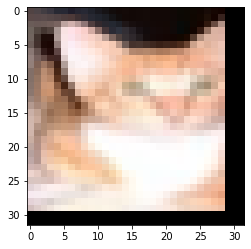

In [49]:
adv_images.shape
plt.imshow(adv_images[1].permute((1,2,0)))

In [38]:
net(adv_images)

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.8569e-10, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000

In [50]:
attackPGD = torchattacks.PGD(net, eps=8/255, alpha=1/255, steps=40, random_start=False)

In [52]:
for data in testloader:
  images, labels = data[0], data[1]
  adv_images = attackPGD(images, labels)

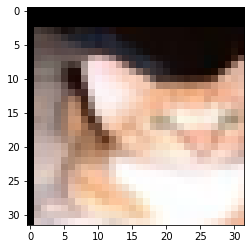

In [54]:
adv_images.shape
plt.imshow(adv_images[1].permute((1,2,0)))

In [53]:
net(adv_images)

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000